# Maximum Likelihood Estimation

In [1]:
import numpy as np, pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
import scipy.stats as stats
import statsmodels.api as sm
from myst_nb import glue

import os
if os.name == 'nt':
    plt.style.use('book.mplstyle')  # Windows

Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 462 ('figure.figsize   : 5, 3   ## figure size in inches')
Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 463 ('figure.dpi       : 100        ## figure dots per inch')


Let's consider the simplest possible scenario, where some force $f_y$ is modelled as function of velocity $v$ and some hydrodynamic coefficient $\beta$:

$$ f_y = \beta \cdot v  $$ (eq_model)

One physical experiment is carried out where the force $f_y$ is measured at a certain speed $v$. (We also measure that there is no force at rest ($v=0$) to confirm the lack of interception term in the model {eq}`eq_model`).

In [55]:
# generate data
np.random.seed(42)
N = 10

beta = 3
scale = 0.5

data = pd.DataFrame()
v = data['v'] = np.linspace(0,5,N)
ϵ = data['ϵ'] = np.random.normal(loc = 0.0, scale = scale, size = N)

f_y = data['f_y'] = beta*v
f_y_measure = data['f_y_measure'] = f_y + ϵ




In [56]:
n = 3
f_y_sample = f_y_measure[n]
v_sample = v[n]
beta_hat = f_y_sample/v_sample
glue("f_y_sample", np.round(f_y_sample, 2), display=False)
glue("v_sample", np.round(v_sample, 2) , display=False)
glue("beta_hat", np.round(beta_hat, 2), display=False)

In [57]:
data['beta'] = data['f_y_measure'] / data['v']
glue("tab_experiments", data[['v','f_y_measure','beta']].round(decimals=2))

,v,f_y_measure,beta
0,0.00,0.25,inf
1,0.56,1.60,2.88
2,1.11,3.66,3.29
3,1.67,5.76,3.46
4,2.22,6.55,2.95
5,2.78,8.22,2.96
6,3.33,10.79,3.24
7,3.89,12.05,3.10
8,4.44,13.10,2.95
9,5.00,15.27,3.05


{glue:}`f_y_sample` [N] force ($f_y$) was measured during the conducted experiment at a speed ($v$) of {glue:}`v_sample` [m/s].  
As the model {eq}`eq_model` contains only one unknown parameter: $\beta$ this one only experiment is enought to determine $\beta$:

$$\beta = \frac{f_y}{v} $$ (eq_beta_deterministic)

So that beta can be estimated as {glue:}`beta_hat`.

If the measurement was perfect and the used model describes the physics perfectly this estimation of $\beta$ is the correct one. In order to double check this several experiment was conducted, as seen in the table below:


```{glue:figure} tab_experiments
:figwidth: 300px
:name: "tab_experiments"
Result from experiments
```

It can be seen that {eq}`eq_beta_deterministic` gives different estimates of $\beta$ from the different experiments. So there must be some measurement errors or model errors (or booth) in the data from these experiments.

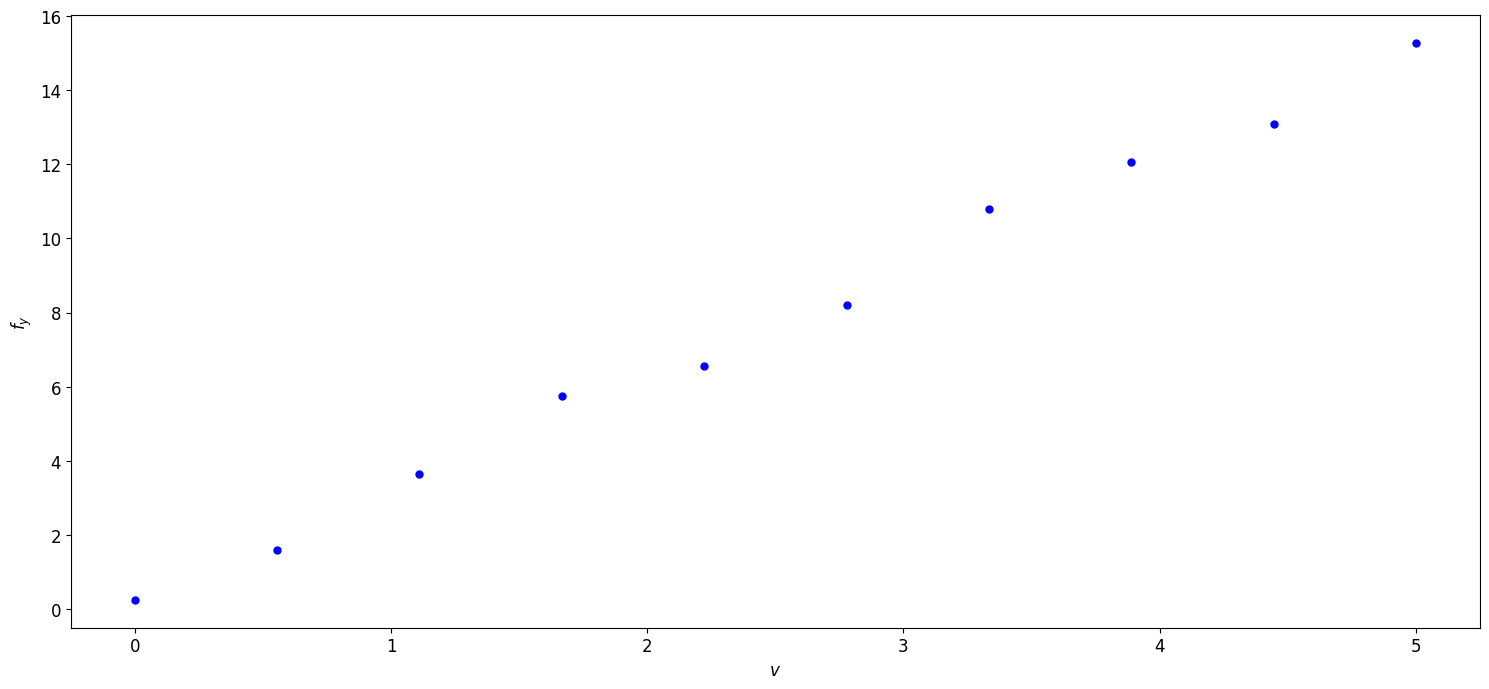

In [58]:
fig,ax=plt.subplots()
data.plot(x='v', y='f_y_measure', style='bo', ax=ax);
ax.set_ylabel(r'$f_y$')
ax.set_xlabel(r'$v$');
ax.get_legend().set_visible(False)

If it is asumed that the deviations comes from measurement errors, it is common to assume that this error $\epsilon$ follows the normal distribution with zero mean and some standard deviation $\sigma$:

$$ \epsilon \sim \mathcal{N}(0,\,\sigma^{2}) $$

The figure below shows a probability density plot (PDF) of a normal distribution for measurement error. It can be seen that having no error $\epsilon=0$ has the highest probability, and values very far away from zero, like +/- 2 N have very low probability.

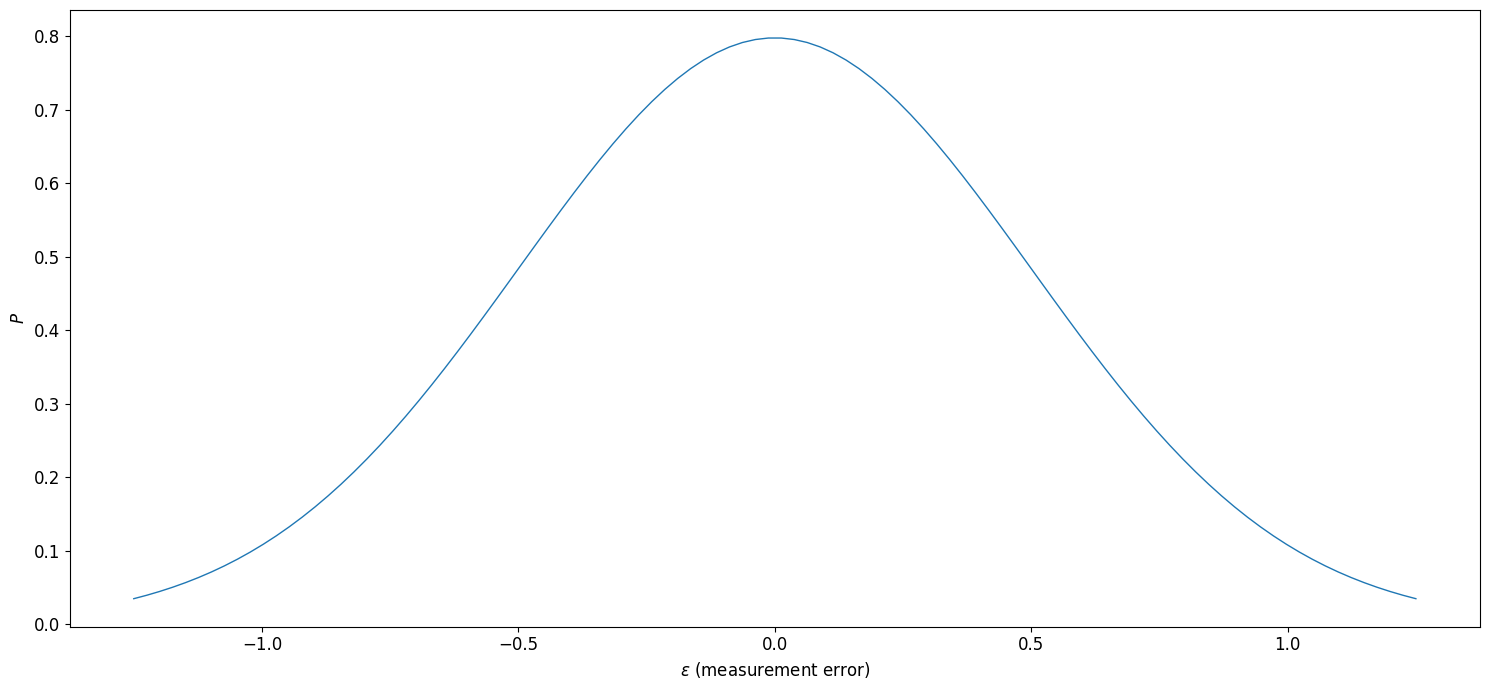

In [59]:
ϵ = stats.norm(loc=0, scale=scale)

epsilons = np.linspace(-2.5*scale,2.5*scale,100)
p = ϵ.pdf(epsilons)

fig,ax=plt.subplots()
ax.plot(epsilons,p);
ax.set_xlabel(r'$\epsilon$ (measurement error)');
ax.set_ylabel(r'$P$');


The measurement error can now be added to the estimation of $f_y$ by modifying the model equation ({eq}`eq_model`):

$$ f_y = \beta \cdot v + \epsilon $$ (eq_model_probabalisic)

The regression problem can now be solved if we can find the normal distribution that created the measurement noise as seen in the figure below.

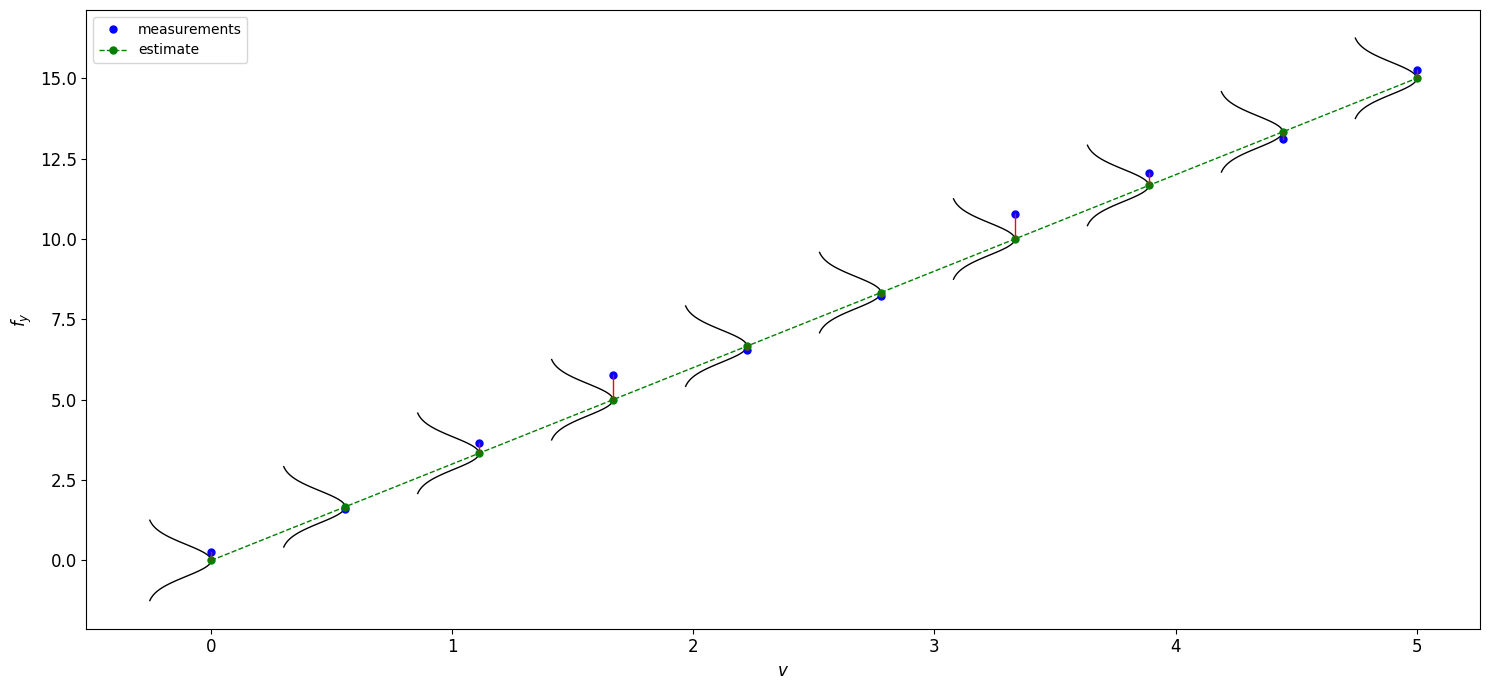

In [60]:
fig,ax=plt.subplots()
data.plot(x='v', y='f_y_measure', style='bo', label='measurements', ax=ax)
data.plot(x='v', y='f_y', style='g--o', label='estimate', ax=ax)

p_ = p/3  # Scaling for figure
p_max = np.max(p_)


for index,row in data.iterrows():
    ax.plot(row['v'] + p_ - p_max, row['f_y'] + epsilons, 'k-', zorder=-10)
    ax.plot([row['v'],row['v']], [row['f_y'],row['f_y_measure']], 'r-') 

ax.set_xlabel(r'$v$');
ax.set_ylabel(r'$f_y$');


We assume that the measurement error distribution is the same for all measurements as seen in the figure above. It does not matter if the speed $v$ is 2 or 5 m/s, we still expect the error to come from the same distibution. And this is where the Maximum Likelihood Estimation comes into play. We want to find the distribution that it is most likely that the measurement error in our data originate from.

The likelihood for one arbitrary distribution is calculated as a product of the likelihoods (y-axis of the PDF) for all data points as seen in the below figure: 

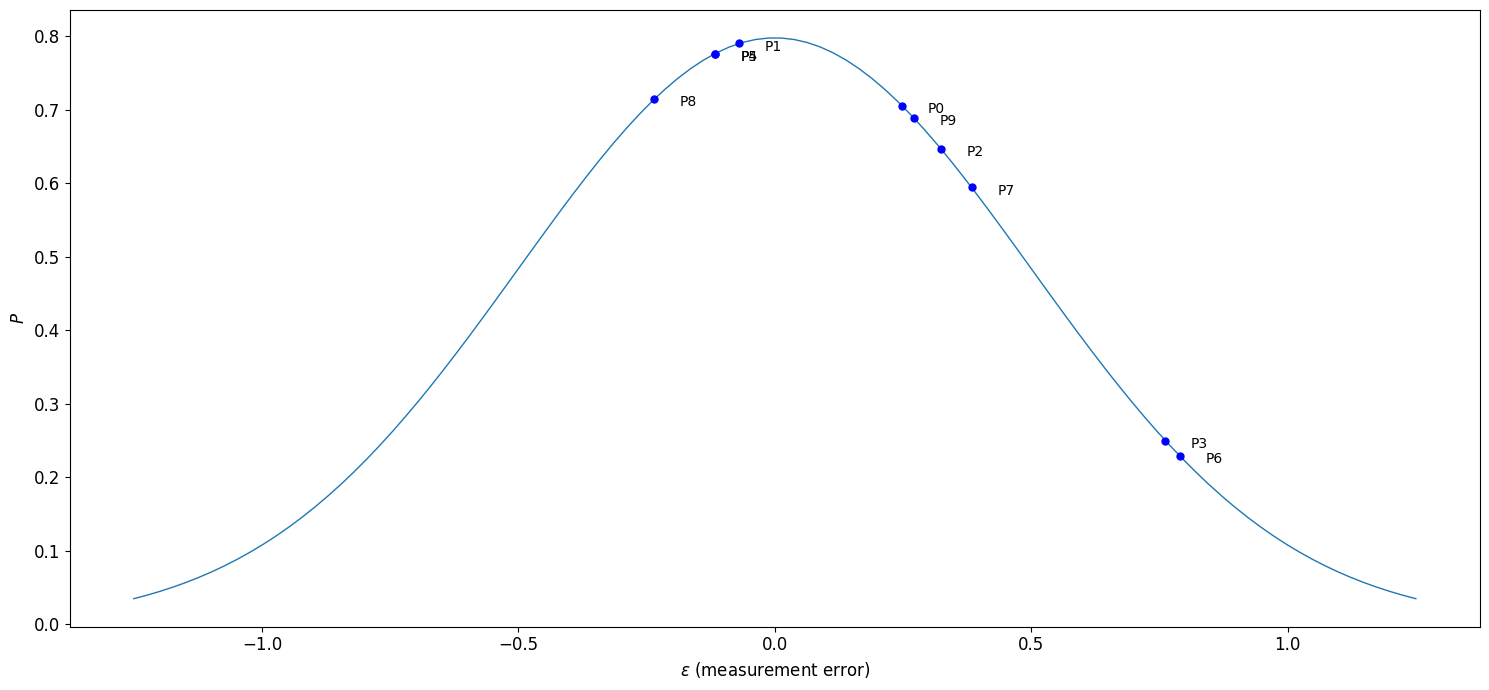

In [61]:
epsilons = np.linspace(-2.5*scale,2.5*scale,100)
p = stats.norm.pdf(epsilons, loc=0, scale=scale)

fig,ax=plt.subplots()
ax.plot(epsilons,p);

data['P'] = ϵ.pdf(data['ϵ'])

data.plot(x='ϵ', y='P', ax=ax, style='bo')
for index,row in data.iterrows():
    ax.text(x=row['ϵ']+0.05, y=row['P']-0.01, s=f'P{index}')


ax.set_xlabel(r'$\epsilon$ (measurement error)');
ax.set_ylabel(r'$P$');
ax.get_legend().set_visible(False)

This can be implemented as a for-loop:

In [62]:
likelihood = 1
for P in data['P']:
    likelihood*=P
likelihood

0.0036463009938397907

This kind of itterative product very quickly gets out of hand, if there is thousands or millions of data points the calculation gets very complicated. So there is a mathematical "trick" to instead used the log(PDF) where the products instead becomes a summation, which is much easier to work with.

The likelihood (or rather log-likelihood) that the data origins from a certain distribution can be calculated in tis way. But how do we know that this is the most likely? Perhas there is another distribution that is more likely than the one we tested above? This turns into an optimization problem, maximizing the likelihood which in the case of a normal distribution with zero mean boils down to determine the standard deviation $\sigma$ of the distribution with highest likelihood. An analytical solution to the optimization problem can be found by finding the point where all the partial derivatives are zero. But instead we will use *scipy.optimize.minimize* to find a numerical solution instead. (The maximization problem needs to be reformulated into a minimization problem of the negative log-likelihood).

In [63]:
# define likelihood function
def MLERegression(params, v, f_y):
    
    # Parameter to be optimized:
    # beta (slope of curve) and 
    # std (standard deviation of the error distribution)
    beta, std = params[0], params[1]
    
    # Random variable with "guessed" standard deviation:
    ϵ = stats.norm(loc=0, scale=std)
    
    # The estimated forces with "guessed" value of beta:
    f_y_hat = beta*v
    
    # This estimation for the forces would give the following error:
    errors = f_y - f_y_hat
    
    # The log-likelihoods of these errors can be calculated with the 
    # log of the ϵ PDF: 
    loglikelihoods = ϵ.logpdf(errors)
    
    # The total likelihood of observing the measured forces f_y can be calculated
    # as the sum of all loglikelihoods:
    likelihood = np.sum( loglikelihoods )
    
    # return negative LL
    return(-likelihood)

In [64]:
# let’s start with some random coefficient guesses and optimize
guess = np.array([5,2])
results = minimize(MLERegression, 
                   guess, 
                   args=(data['v'].values,data['f_y_measure'].values,), 
                   method = "Nelder-Mead")

In [65]:
results

 final_simplex: (array([[3.06186931, 0.36619199],
       [3.06189338, 0.36626719],
       [3.06185476, 0.36627036]]), array([4.1446801 , 4.14468012, 4.14468013]))
           fun: 4.1446801018249015
       message: 'Optimization terminated successfully.'
          nfev: 93
           nit: 50
        status: 0
       success: True
             x: array([3.06186931, 0.36619199])

In [66]:
beta_hat = results.x[0]
scale_hat = results.x[1]
data['f_y_hat'] = beta_hat*data['v']

glue("beta_hat", np.round(beta_hat, 2))
glue("scale_hat", np.round(scale_hat, 2))


3.06

0.37

So the optimizer has found $\hat{\beta}$ = {glue:}`beta_hat` to be the most likely esimate for $\beta$ and $\hat{\sigma}$ = {glue:}`scale_hat` to be the most likely standard deviation of the measurement error. 
In this toy example the experimental data was in fact not taken from a real physical experiment but was randomly generated using the assumed model {eq}`eq_model_probabalisic`. So we can have a look at how well the esimated slope and error distribution correspond to the real model that generated the data: 

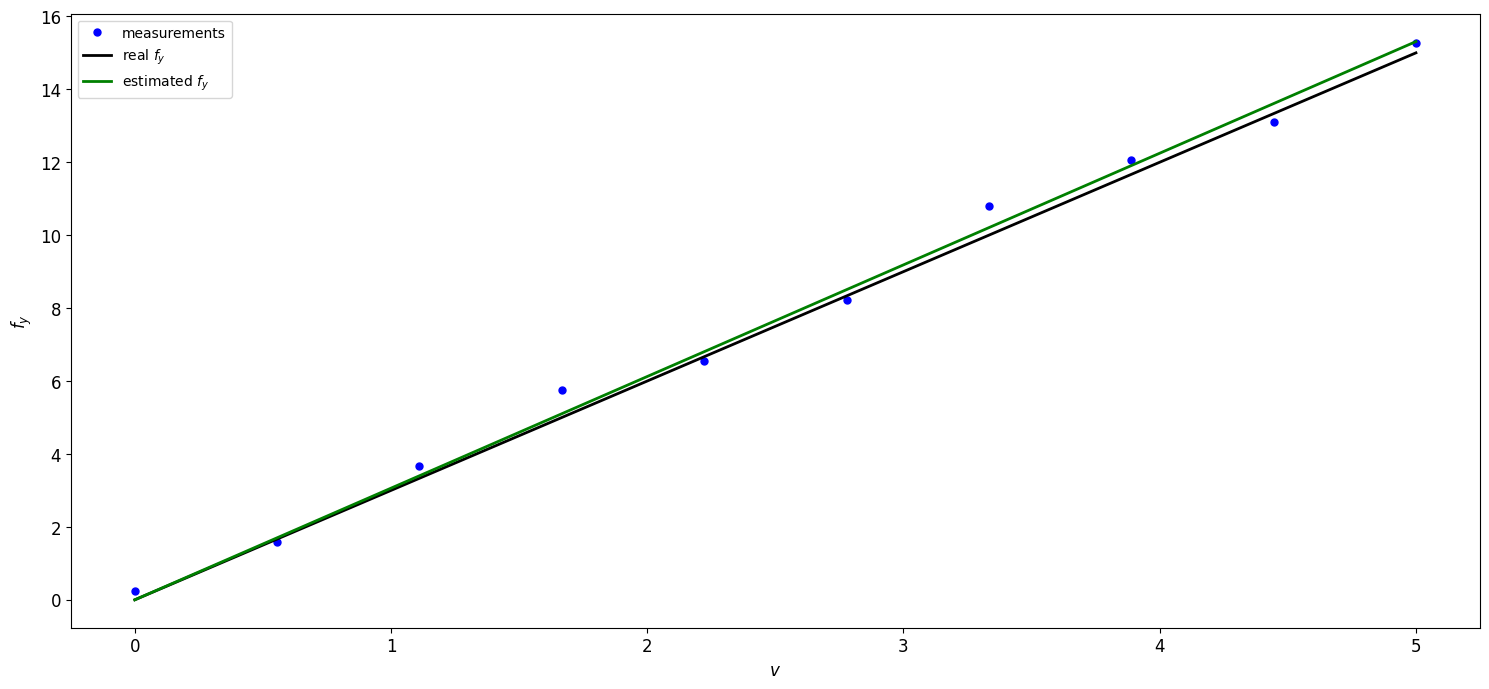

In [69]:
fig,ax=plt.subplots()
data.plot(x='v', y='f_y_measure', style='bo', label='measurements', ax=ax);
data.plot(x='v', y='f_y', style='k-', label='real $f_y$', lw=2, ax=ax);
data.plot(x='v', y='f_y_hat', style='g-', label='estimated $f_y$', lw=2, ax=ax);

ax.set_ylabel(r'$f_y$')
ax.set_xlabel(r'$v$');

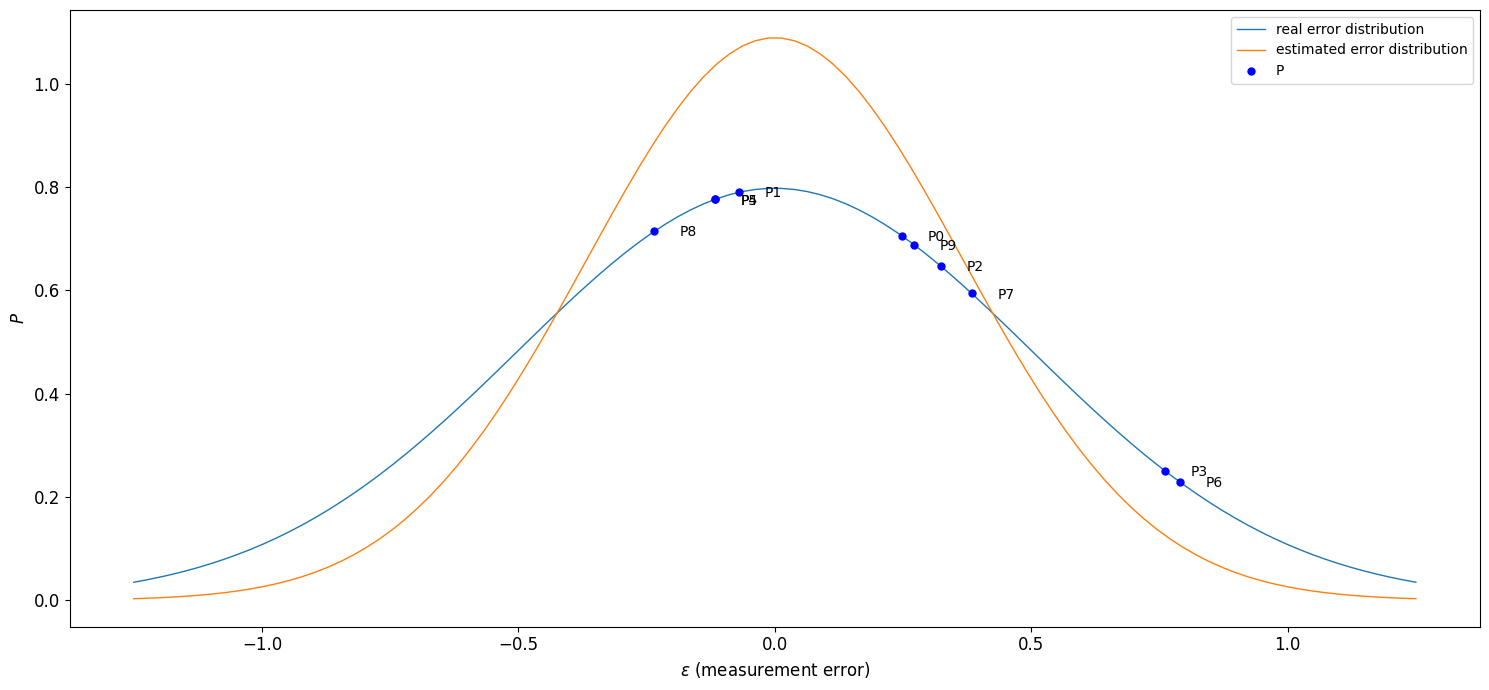

In [68]:
epsilons = np.linspace(-2.5*scale,2.5*scale,100)
p = stats.norm.pdf(epsilons, loc=0, scale=scale)
fig,ax=plt.subplots()
ax.plot(epsilons,p, label='real error distribution');

p_estimate = stats.norm.pdf(epsilons, loc=0, scale=scale_hat)
ax.plot(epsilons,p_estimate, label='estimated error distribution');



data['P'] = ϵ.pdf(data['ϵ'])

data.plot(x='ϵ', y='P', ax=ax, style='bo')
for index,row in data.iterrows():
    ax.text(x=row['ϵ']+0.05, y=row['P']-0.01, s=f'P{index}')


ax.set_xlabel(r'$\epsilon$ (measurement error)');
ax.set_ylabel(r'$P$');
ax.legend();

## Discussion
The Maximum Likelihood Estimation seems to work well to regress the unknown parameter $\beta$ on the measurement data. But this was a situation where the model {eq}`eq_model` choosen for the regression described the underlying physics really well (in fact it was the exact correct model). This is of course never the case when real data from real physical experiments are used. 

Eventhough the regressed model seems to be correct, we can never be entirely sure. The scattered results from the experiments does not necesarrily origin from just measurement errors, but can also come from errors in the model as process noise. What if there was actually no measurement error at all and the model is instead a function of not just velocity $v$ but also some hidden variable $u$: 

$$ f_y = \beta \cdot v + u $$ (eq_model_u)

Comparing this expression with the one we used:

$$ f_y = \beta \cdot v + \epsilon $$ (eq_model_u)

It can be realized that this model could also have created the data if $u=\epsilon$. Which can also be seen in the python implementation below.

In [93]:
np.random.seed(42)
N = 10

beta = 3
gamma = 1
scale = 0.5

data2 = pd.DataFrame()
u = data2['u'] = np.random.normal(loc = 0.0, scale = scale, size = N)
v = data2['v'] = np.linspace(0,5,N)

f_y = data2['f_y'] = beta*v + gamma*u
f_y_measure = data2['f_y_measure'] = f_y

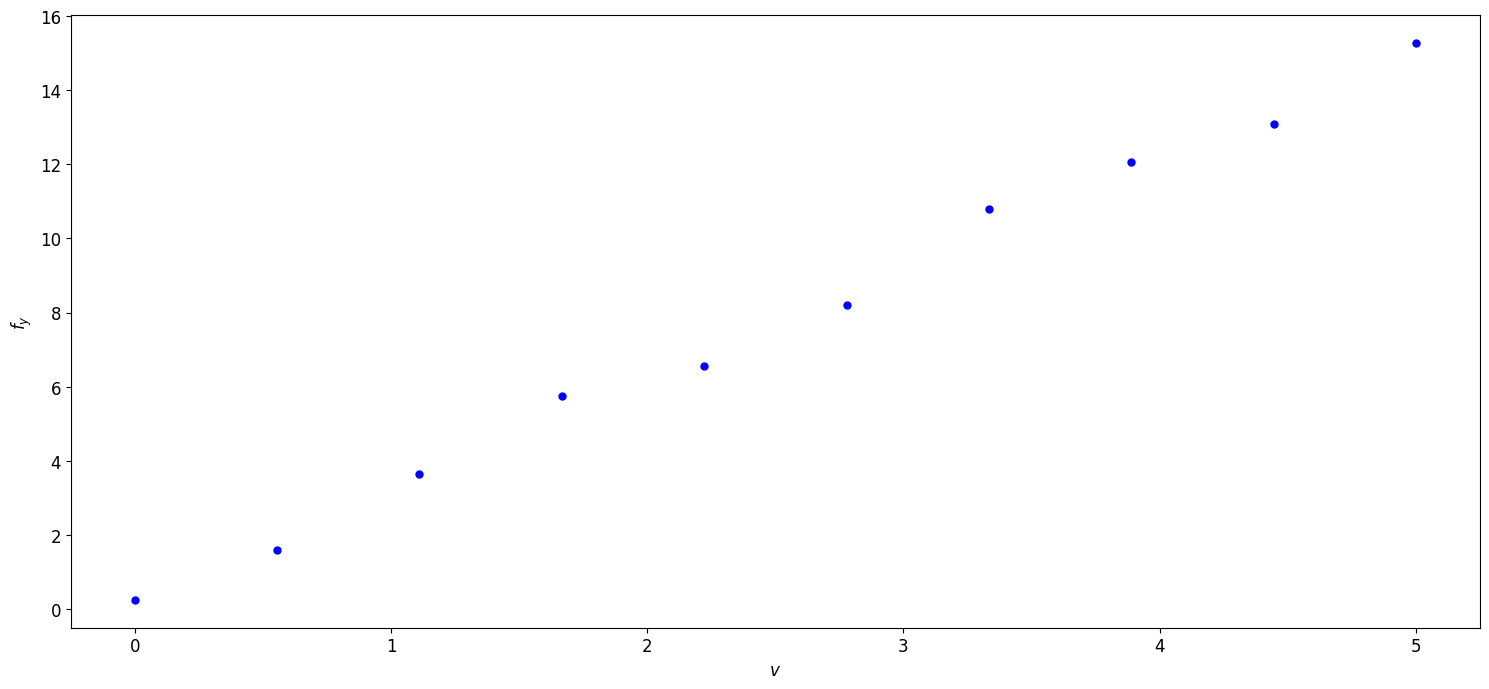

In [94]:
fig,ax=plt.subplots()
data2.plot(x='v', y='f_y_measure', style='bo', ax=ax);
ax.set_ylabel(r'$f_y$')
ax.set_xlabel(r'$v$');
ax.get_legend().set_visible(False)

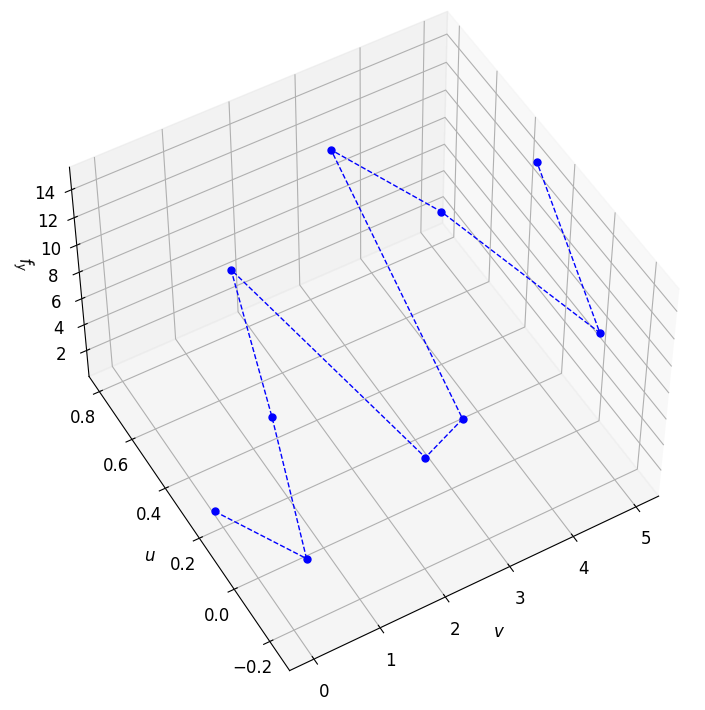

In [95]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot(data2['v'], data2['u'], data2['f_y_measure'], 'bo--',)
ax.set_zlabel(r'$f_y$')
ax.set_xlabel(r'$v$');
ax.set_ylabel(r'$u$');
ax.view_init(elev=50., azim=-120)


If $u$ is not included in the model it will end up in the process error $w$ so that the model is written:

$$ f_y = \beta \cdot v + w $$ (eq_model_w)

This is the model that we believe generated the data and we can observe this model by conducting experiments where also measurement error is introduced:

$$ f_{y}^{measured} = f_y + \epsilon $$ (eq_model_measure)